# 1. Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.io import imread
from PIL import Image 
import matplotlib.font_manager as fm
from matplotlib_scalebar.scalebar import ScaleBar

# 2. Map loading

In [ ]:
#reading of image
img_pil = Image.open("map3.pgm") 

# 3. Preprocessing

### Rotate image
### convert to binary image
### invert image to use edge detection
### Apply filters for better feature extraction

In [6]:
rotate_img= img_pil.rotate(4,expand=1,fillcolor=(205))
img = np.array(rotate_img)
rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
rgb_copy = rgb.copy()

# trinary to binary image
idx_grey = img==205
binary_img = img.copy()
binary_img[idx_grey]=255
binary_img =cv2.threshold(img,210,255,cv2.THRESH_BINARY)[1]

# invert image for processing
inv_img = ~binary_img 

In [8]:
def plot_imgs(imgs):    
    fig = plt.figure(figsize=(20, 10))
    
    # setting values to rows and column variables
    rows = 1
    columns = len(imgs)
    
    for idx, img_ in enumerate(imgs):
    
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, idx+1)
    
        # showing image
        plt.imshow(img_,cmap='gray')
        plt.axis('off')
        plt.title("Raw")

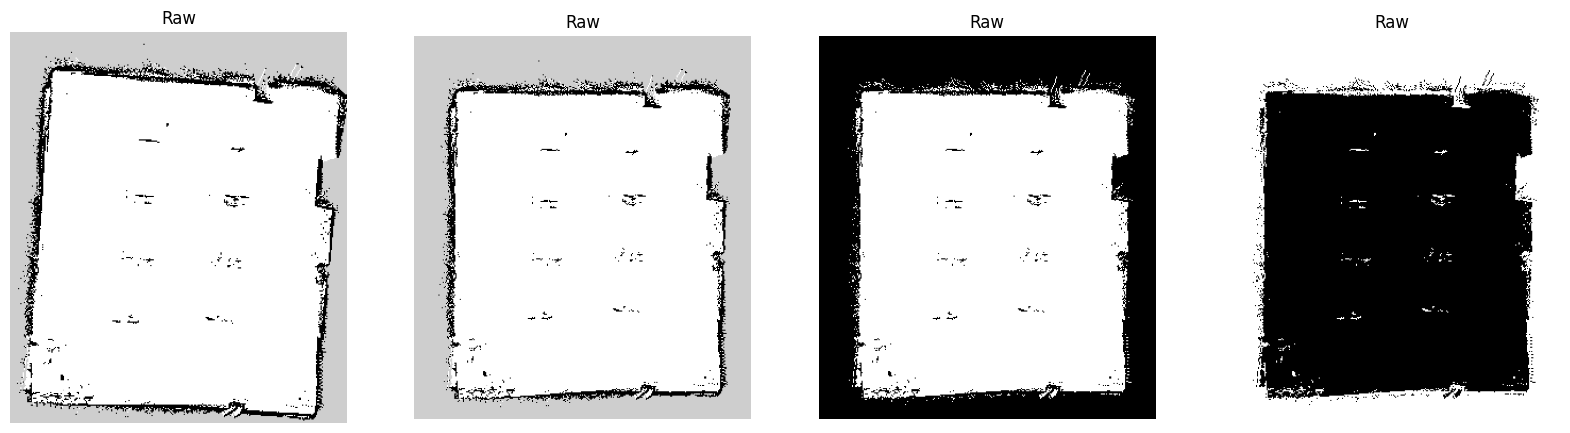

In [9]:
plot_imgs([img_pil, img, binary_img, inv_img])

In [11]:
# tryout of different filters, none of them were actually beneficial
kernel_size = 3
blur_gray = cv2.GaussianBlur(img,(kernel_size, kernel_size),0)
sharpened = cv2.bilateralFilter(img, 9, 75, 75)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
morph = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
kernel_sharp = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpened_morph = cv2.filter2D(morph, -1, kernel_sharp)
kernel_close = np.ones((50, 50), np.uint8)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close)
kernel = np.ones((5,5),np.uint8)
dil = cv2.dilate(binary_img,kernel,iterations=2)

# 4. Blob detection of obstacles

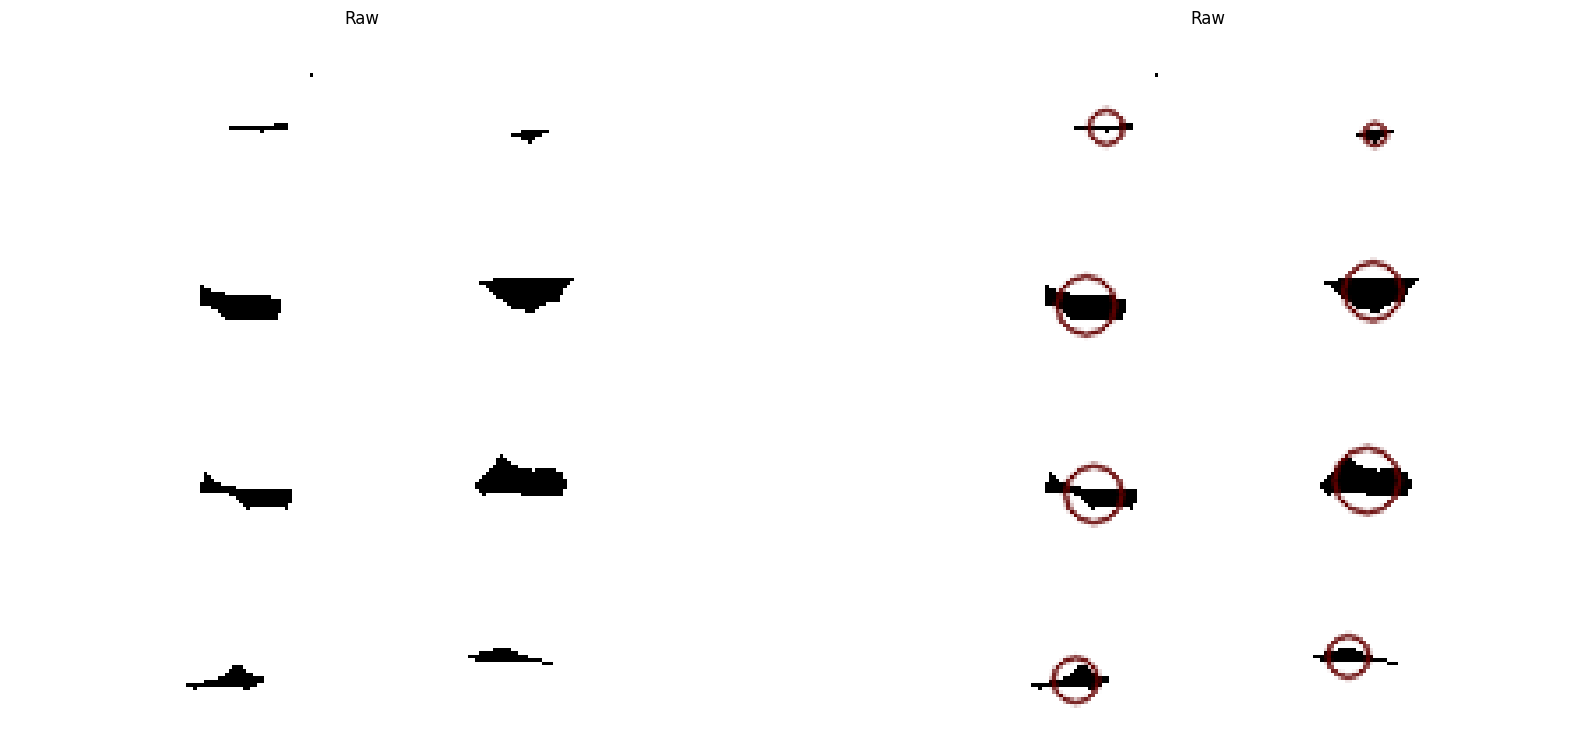

In [27]:
# blob detection in the middle of the image --> ROI
c1 = int(morph.shape[0]/2)
r1 = int(morph.shape[1]/2)

#ROI
roi_morph = morph[c1-100:c1+100,r1-100:r1+100]
data = roi_morph / roi_morph.max() #normalizes data in range 0 - 255
data = 255 * data
roi_morph = data.astype(np.uint8)
detector = cv2.SimpleBlobDetector()
 
# Detect blobs.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 200


# Filter by Area.
params.filterByArea = True
params.minArea = 10

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.01

# Create a detector with the parameters

# OLD: detector = cv2.SimpleBlobDetector(params)
detector = cv2.SimpleBlobDetector_create(params)


# Detect blobs.
keypoints = detector.detect(roi_morph)
# use of keypoints later!!!
im_with_keypoints = cv2.drawKeypoints(roi_morph, keypoints, np.array([]), (100), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_imgs([roi_morph, im_with_keypoints])

# 5. Canny Edge detection of ground plan
### Detect all possible edges
### use biggest edge to calculate area

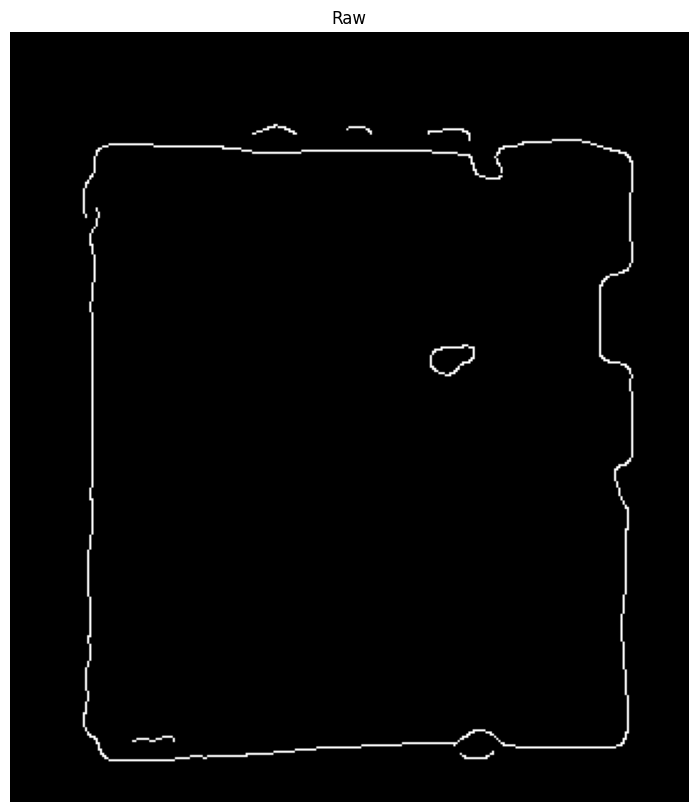

In [28]:
#Edge detection on image
from scipy import ndimage as ndi
from skimage import feature


sig= 3.9
edges_bin = feature.canny(binary_img, sigma=sig)
edges_inv = feature.canny(inv_img, sigma=sig)
edges_blur = feature.canny(blur_gray, sigma=sig)
edges_morph = feature.canny(morph, sigma=sig)
edges_imgs = [edges_bin]


plot_imgs(edges_imgs)


In [29]:
# Contour and polygon detection
edges_closed_arr = []
areas = []
polygons = []
for edge_img in edges_imgs:
    data = edges_bin / edges_bin.max() #normalizes data in range 0 - 255
    data = 255 * data
    gray_edges_bin = data.astype(np.uint8)
    kernel_close = np.ones((5, 5), np.uint8)
    edges_closed=cv2.morphologyEx(gray_edges_bin, cv2.MORPH_CLOSE, kernel_close)
    contours,_=cv2.findContours(edges_closed, cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)
   
    # Searching through every region selected to 
    # find the required polygon.
    result = []
    max_area = 0
    max_poly = None
    for cnt in contours :
        area = cv2.contourArea(cnt)
    
        # Shortlisting the regions based on there area.
        if area > max_area: 
            max_poly = cv2.approxPolyDP(cnt, 
                                  0.009 * cv2.arcLength(cnt, True), True)
            max_area = area
    areas.append(max_area)
    polygons.append(max_poly)
# generate
area = areas[0]
polygon = polygons[0]
print("area is around ", area*9/10000, "m2")

area is around  62.76825 m2


In [34]:
# save of postprocessed
def plot_postprocessed(rgb, polygon, area, keypoints,color):
    plt.figure(figsize=(20, 10))

    
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    # org
    org = (5, 20)
  
    # fontScale
    fontScale = 0.6
   
    # Red color in BGR
    color = color
  
    # Line thickness of 2 px
    thickness = 2
    cv2.putText(rgb, 'Area = {} m2'.format(round(area*9/10000,2)), org, font, 
                   fontScale, color, 1, cv2.LINE_AA)
    cv2.drawContours(rgb, [polygon], 0, color,thickness)
    convert_keypoints = cv2.KeyPoint_convert(keypoints)
    for kp in convert_keypoints:
        pad_x = (rgb.shape[1]-200)/2
        pad_y = (rgb.shape[0]-200)/2
        start_point_x = int( kp[0]+ (pad_x)-10)
        start_point_y = int(kp[1] +(pad_y)-5)

        end_point_x = int(kp[0]+(pad_x)+10)
        end_point_y = int(kp[1]+(pad_y)+5)
        start_point = [start_point_x, start_point_y]
        end_point = [end_point_x, end_point_y]
        cv2.rectangle(rgb, start_point, end_point, color, thickness)
    plt.imshow(rgb)
    scalebar = ScaleBar(0.03, location="lower center",fixed_value=8, color= "blue") # 1 pixel = 0.2 meter
    scalebar2 = ScaleBar(0.03, location="center right", rotation="vertical", fixed_value=10, color="blue") # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.gca().add_artist(scalebar2)
    plt.axis('off')
    plt.savefig('postprocessed.png',transparent=True)



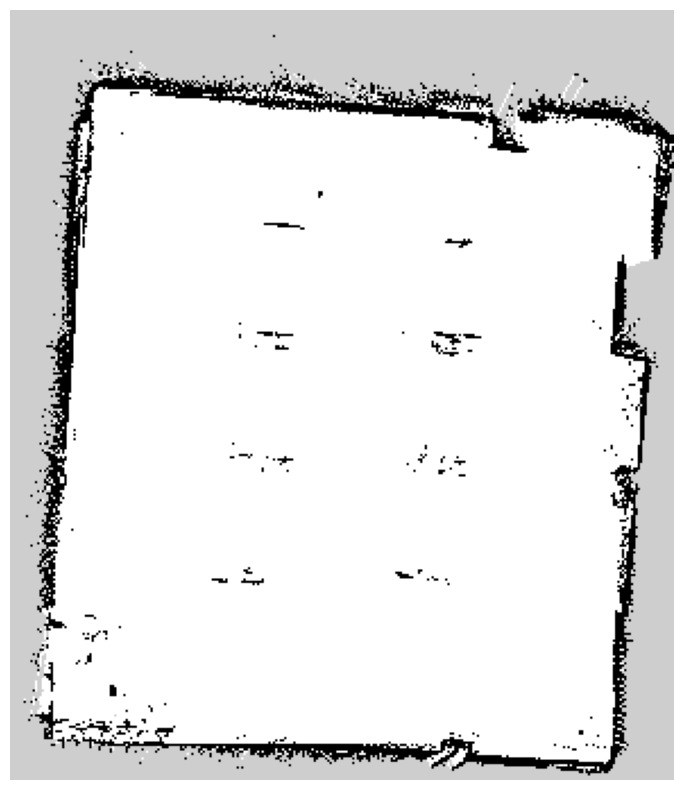

In [35]:
#save of original
plt.figure(figsize=(20, 10))
plt.imshow(img_pil, cmap="gray")
plt.axis('off')
plt.savefig('raw.png',transparent=True)

# 6. Construct final image
### mark ground plan edges
### mark obstacles
### show calculated area

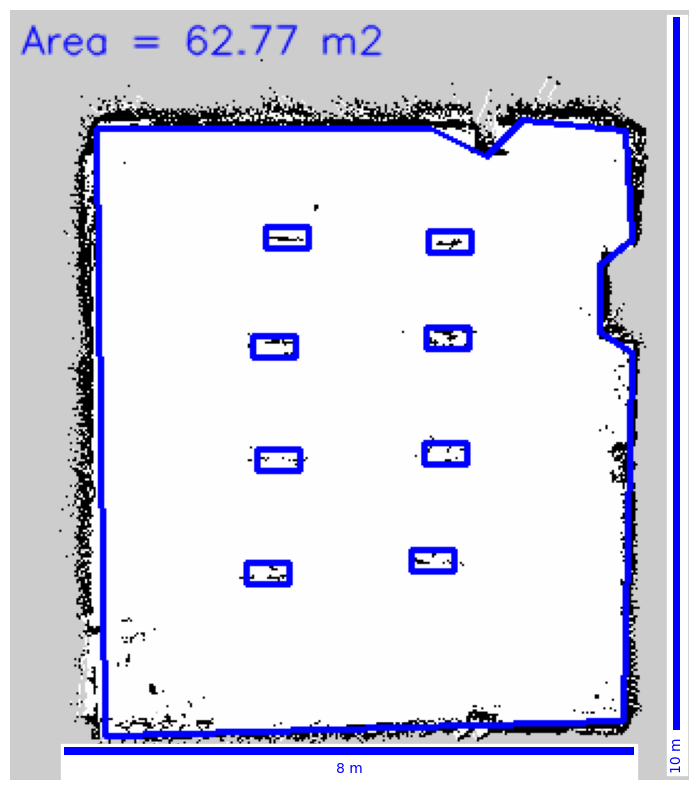

In [36]:
rgb_copy = rgb.copy()
plot_postprocessed(rgb_copy,polygon, area,keypoints,(0,0,255))